# 🏠 House Prices 이상값(outlier) 분석 실습 (문제용)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 사용해
이상값(outlier)을 탐지하고 처리(drop/clip)하는 과정을 실습하기 위한 문제집입니다.

주요 목표
1. 이상값 후보 시각화(Boxplot, Scatter)
2. IQR 기반 이상값 경계 계산
3. 이상치 행 추출/분석
4. 이상치 처리 전략 (제거 vs 클리핑)
5. 처리 전/후 데이터 분포 비교 및 해석

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("./data/05_House Prices - Advanced Regression Techniques.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 핵심 수치형 변수 살펴보기
- 아래 변수들에 대해 describe()로 기본 통계를 확인하세요.
  - SalePrice (집값)
  - LotArea (대지 면적)
  - GrLivArea (지상 생활 면적)
  - GarageArea (차고 면적)
- 어느 변수가 특히 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포처럼 보이는지 적으세요.

In [3]:
# TODO: df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T
df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
GarageArea,1460.0,472.980137,213.804841,0.0,334.5,480.0,576.00,1418.0


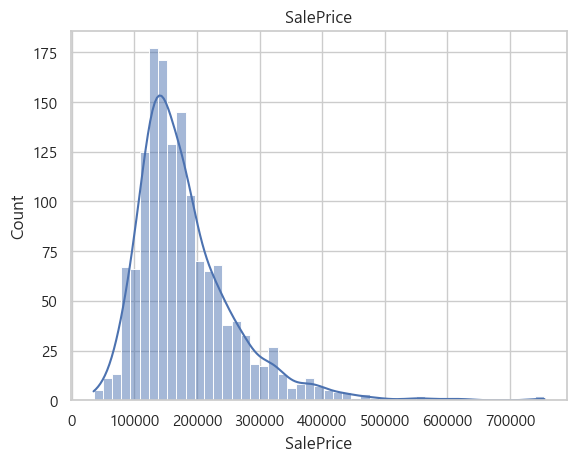

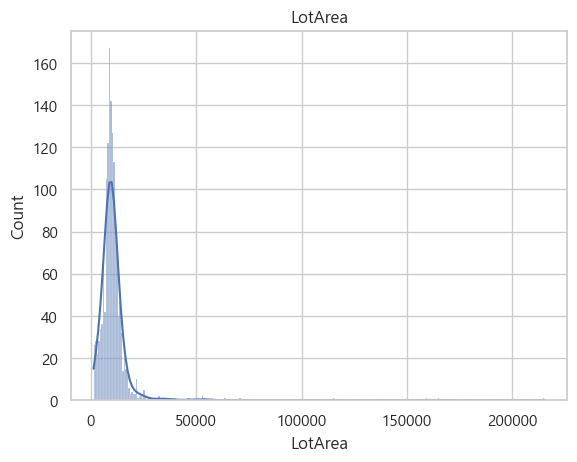

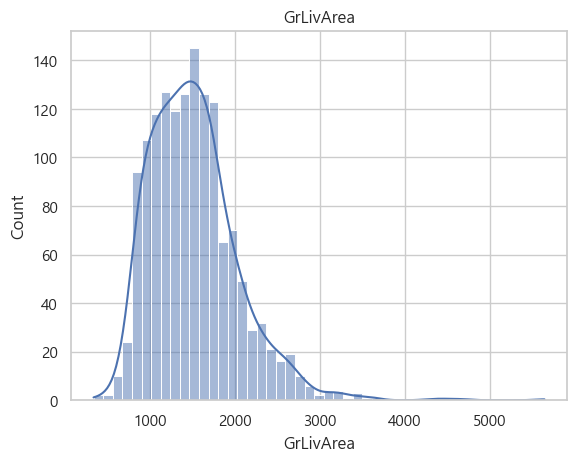

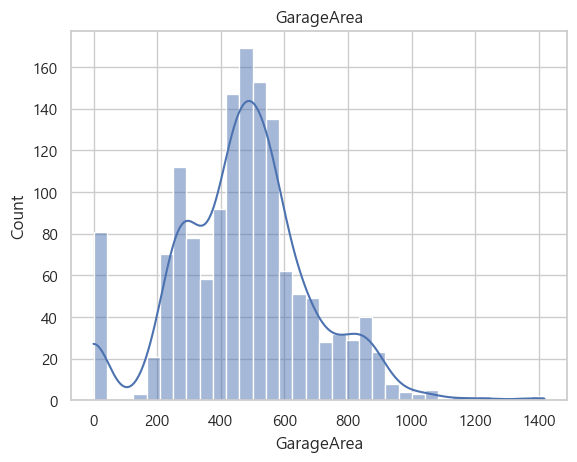

In [4]:
cols = ['SalePrice', 'LotArea', 'GrLivArea', 'GarageArea']
for col in cols:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

> mean > median 이면 오른쪽 꼬리<br>
max가 75%보다 훨씬 크면 극단치가 많음<br>
-> 이 데이터에서는 LotArea, GrLivArea, SalePrice가 오른쪽 꼬리 길고<br>
GarageArea는 상대적으로 대칭적

## 문제 2️⃣: 박스플롯 & 산점도 시각화
1. `SalePrice`, `LotArea`, `GrLivArea`, `GarageArea` 각각 박스플롯(boxplot)으로 시각화하세요.
2. `GrLivArea` vs `SalePrice` 산점도를 그려서, 면적이 큰 집이 정말 비싼지/이상하게 싼지 확인하세요.

In [5]:
# TODO:
# 1) 각 컬럼별 boxplot
# 2) GrLivArea vs SalePrice 산점도

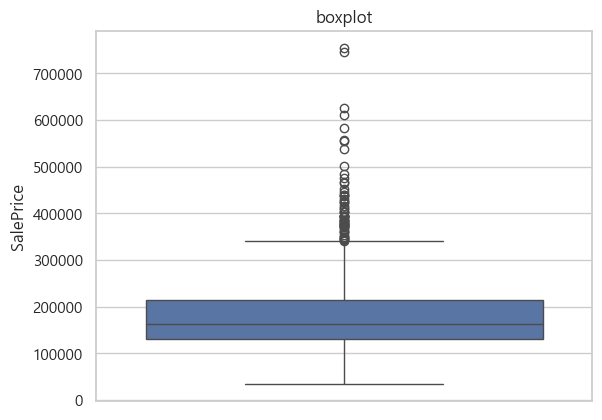

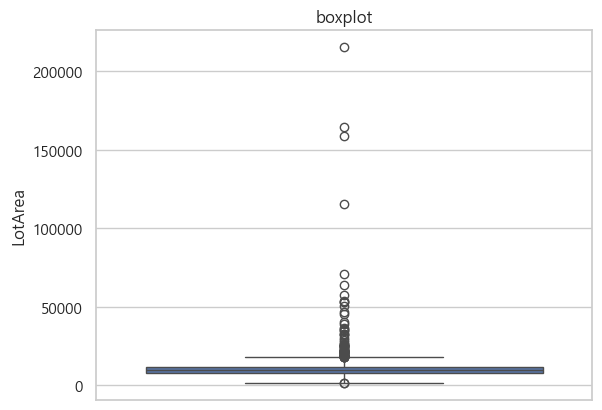

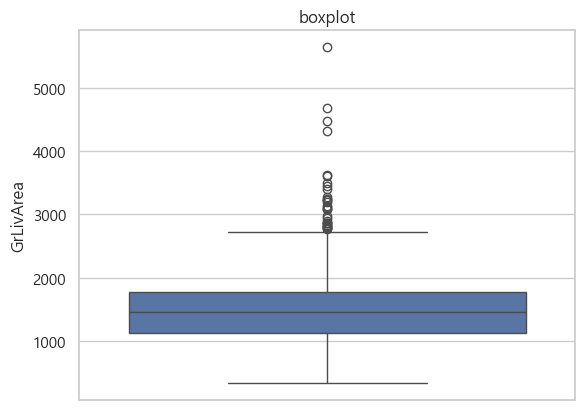

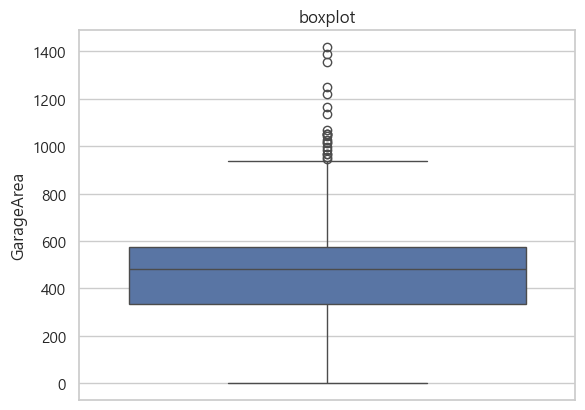

In [6]:
cols = ['SalePrice', 'LotArea', 'GrLivArea', 'GarageArea']
for col in cols:
    sns.boxplot(df[col],fill=True)
    plt.title("boxplot")
    plt.show()

GrLivArea vs SalePrice 산점도를 그려서, 면적이 큰 집이 정말 비싼지/이상하게 싼지 확인하세요.

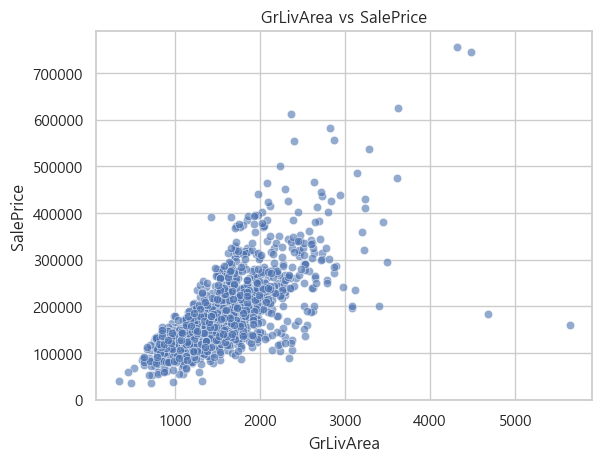

In [7]:
plt.figure()
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, alpha=0.6)
plt.title('GrLivArea vs SalePrice')
plt.show()

> 면적이 클수록 집값도 비싸다

## 문제 3️⃣: IQR 기반 이상값 경계 (SalePrice)
1. `SalePrice`의 Q1(25%), Q3(75%), IQR(Q3-Q1)을 구하세요.
2. IQR 방식으로 lower_bound, upper_bound를 계산하세요.
   - lower = Q1 - 1.5 * IQR
   - upper = Q3 + 1.5 * IQR
3. 이 범위를 벗어나는 행의 개수와, 전체 대비 비율(%)을 구하세요.

In [8]:
# TODO:
# Q1,Q3,IQR 계산 후 IQR 기반 하한/상한, 이상치 개수와 비율 계산
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

In [9]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [10]:
outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]

In [11]:
outlier_count = len(outliers)
total_count = len(df)
outlier_ratio = (outlier_count / total_count) * 100

print(f"Q1 (25%): {Q1}")
print(f"Q3 (75%): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print(f"이상치 개수: {outlier_count}")
print(f"이상치 비율: {outlier_ratio:.2f}%")

Q1 (25%): 129975.0
Q3 (75%): 214000.0
IQR: 84025.0
Lower bound: 3937.5
Upper bound: 340037.5
이상치 개수: 61
이상치 비율: 4.18%


## 문제 4️⃣: 면적 관련 이상값 탐지 (GrLivArea, LotArea)
GrLivArea와 LotArea 각각에 대해:
1. Q1, Q3, IQR 계산
2. lower_bound, upper_bound 계산
3. 경계를 벗어나는 데이터 개수 출력
4. GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고,
   '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.

In [12]:
# TODO:
# GrLivArea, LotArea에 대해 IQR 이상치 개수 계산 후
# GrLivArea 이상치 샘플들의 GrLivArea, SalePrice, OverallQual, Neighborhood를 확인

In [13]:
def find_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    print(f"{col}이상치 개수: {len(outliers)}")
    return outliers, lower_bound, upper_bound

# GrLivArea 이상치
gr_outliers, gr_lower, gr_upper = find_outliers_iqr(df, 'GrLivArea')

# LotArea 이상치
lot_outliers, lot_lower, lot_upper = find_outliers_iqr(df, 'LotArea')

# GrLivArea 이상치 중 면적은 크지만 집값은 낮은 경우 확인
median_price = df['SalePrice'].median()
unusual_cases = gr_outliers[(gr_outliers['GrLivArea'] > gr_upper) & (gr_outliers['SalePrice'] < median_price)]

print("면적은 엄청 큰데 집값은 상대적으로 안 비싼 케이스:")
print(unusual_cases[['GrLivArea', 'SalePrice']])


GrLivArea이상치 개수: 31
LotArea이상치 개수: 69
면적은 엄청 큰데 집값은 상대적으로 안 비싼 케이스:
      GrLivArea  SalePrice
1298       5642     160000


## 문제 5️⃣: 이상치 상세 살펴보기
위에서 찾은 GrLivArea 이상치들만 따로 df_outlier_area 데이터프레임으로 저장하고
해당 샘플들의 `GrLivArea`, `SalePrice`, `OverallQual`, `Neighborhood`를 출력하세요.
이 샘플들이 특정 동네에 몰려 있는지, 품질 점수(OverallQual)가 낮은데 크기만 큰 집은 있는지 서술하세요.

In [17]:
# TODO:
# df_outlier_area를 만들고 주요 컬럼만 출력하여 특징을 관찰하세요.
df_outlier_area = gr_outliers[['GrLivArea','SalePrice','OverallQual','Neighborhood']]
df_outlier_area

,GrLivArea,SalePrice,OverallQual,Neighborhood
58,2945,438780,10,StoneBr
118,3222,320000,7,SawyerW
185,3608,475000,10,OldTown
197,3112,235000,8,NAmes
231,2794,403000,8,NoRidge
304,3493,295000,7,OldTown
324,2978,242000,7,NAmes
496,3228,430000,8,NoRidge
523,4676,184750,10,Edwards
583,2775,325000,10,OldTown


In [18]:
df_outlier_area['Neighborhood'].value_counts()

Neighborhood
NoRidge    8
OldTown    4
StoneBr    3
NAmes      2
Edwards    2
NWAmes     2
Crawfor    2
SWISU      2
NridgHt    2
SawyerW    1
Timber     1
CollgCr    1
ClearCr    1
Name: count, dtype: int64

> NoRidge, OldTown, StoneBr 등 일부 동네에 이상치가 집중되어 있음<br>
 품질 낮은데 크기만 큰 집 : OverallQual 5~6 수준이면서 GrLivArea가 큰 샘플 존재

## 문제 6️⃣: 이상치 처리 전략 1 - 제거(drop)
GrLivArea를 기준으로 IQR 바깥의 이상치를 제거한 새로운 DataFrame `df_clean_drop`을 만드세요.
1. 제거 전(df) vs 제거 후(df_clean_drop)의 행 수 비교
2. 두 데이터프레임 각각에서 GrLivArea의 평균, 표준편차 비교

In [ ]:
# TODO:
# df_clean_drop을 만들고 행 수/평균/표준편차를 비교하세요.

In [19]:
df_clean_drop = df[(df['GrLivArea'] >= lower_bound) & (df['GrLivArea'] <= upper_bound)]

In [20]:
print("제거 전:", df.shape[0])
print("제거 후:", df_clean_drop.shape[0])

제거 전: 1460
제거 후: 4


In [21]:
print("제거 전 평균:", df['GrLivArea'].mean())
print("제거 전 표준편차:", df['GrLivArea'].std())

print("제거 후 평균:", df_clean_drop['GrLivArea'].mean())
print("제거 후 표준편차:", df_clean_drop['GrLivArea'].std())

제거 전 평균: 1515.463698630137
제거 전 표준편차: 525.4803834232025
제거 후 평균: 4777.5
제거 후 표준편차: 594.8520824541173


## 문제 7️⃣: 이상치 처리 전략 2 - 클리핑(윈저라이징)
1. GrLivArea의 IQR 기반 lower_bound~upper_bound를 이용해
   GrLivArea를 그 범위 안으로 `clip()` 한 DataFrame `df_clip`을 만드세요.
2. 원본 df와 df_clip 각각에 대해 GrLivArea의 boxplot을 나란히 그리고 비교하세요.
3. 제거(drop) 방식과 비교했을 때 클리핑의 장단점을 서술하세요.

In [ ]:
# TODO:
# df_clip을 만들고, 원본 vs df_clip의 GrLivArea boxplot을 비교 시각화하세요.

In [22]:
df_clip = df.copy()
df_clip['GrLivArea'] = df_clip['GrLivArea'].clip(lower=lower_bound, upper=upper_bound)

In [25]:
import matplotlib.pyplot as plt

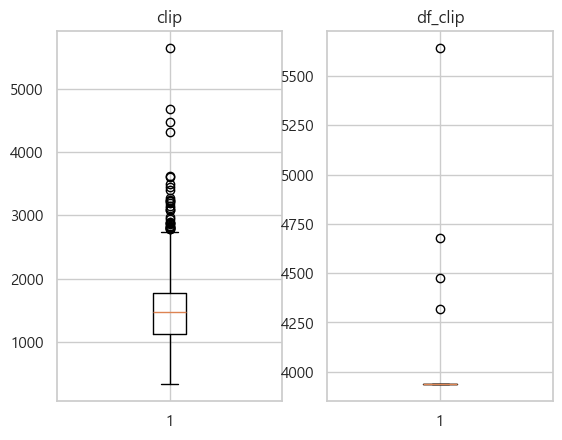

In [26]:
plt.figure()
plt.subplot(1,2,1)
plt.boxplot(df['GrLivArea'])
plt.title('clip')

plt.subplot(1,2,2)
plt.boxplot(df_clip['GrLivArea'])
plt.title('df_clip')

plt.show()

> **제거(drop) 방식과 비교했을 때 클리핑의 장단점을 서술하세요.**<br>
이상치가 너무 큰 영향을 주거나 샘플 손실이 큰 경우에는 clip, <br>
데이터가 충분할 땐 drop 사용


## 문제 8️⃣: 이상치 처리 후 SalePrice 영향
1. 원본 df, df_clean_drop, df_clip 각각에서 SalePrice의 평균과 표준편차를 비교하세요.
2. 극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는지 서술하세요.
3. 만약 '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절하다고 생각하나요?

In [ ]:
# TODO:
# df, df_clean_drop, df_clip 각각의 SalePrice 평균/표준편차를 출력하고 해석하세요.

In [27]:
print("df: ")
print(df['SalePrice'].mean(), df['SalePrice'].std())

#이사이 제거 후 
print("df_clean_drop: ")
print(df_clean_drop['SalePrice'].mean(), df_clean_drop['SalePrice'].std())

# 클리핑 후
print("df_clip: ")
print(df_clip['SalePrice'].mean(), df_clip['SalePrice'].std())

df: 
180921.19589041095 79442.50288288662
df_clean_drop: 
461187.5 333669.9576302907
df_clip: 
180921.19589041095 79442.50288288662


2. 극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는지 서술하세요.<br>
3. 만약 '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절하다고 생각하나요?

> 2. 극단적으로 비싼 집 한두 채가 평균을 크게 끌어올릴 수 있음 -> 실제 일반 주택 가격과 괴리 생김<br>

> 3. 클리핑은 데이터 손실 없이 안정적인 값으로 처리가 가능하기 때문에 클리핑 사용

## 문제 9️⃣: 다변량 관점의 이상치
1. 산점도(GrLivArea vs SalePrice)를 다시 그리되,
   - GrLivArea가 IQR 상한보다 큰데
   - SalePrice는 전체 평균보다 낮은 샘플만 다른 색(예: 빨간색)으로 표시하세요.
2. 이런 집은 어떤 의미일 수 있는지 해석을 적으세요

In [ ]:
# TODO:
# mask_suspicious 조건에 해당하는 점들을 빨간색으로 강조 표시한 산점도를 그리세요.

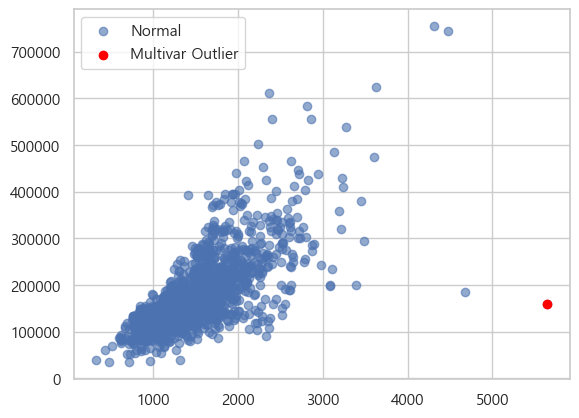

In [28]:
# SalePrice 평균
price_mean = df['SalePrice'].mean()
# 다변량 이상치 선택
multivar_outliers = df[(df['GrLivArea'] > gr_upper) & (df['SalePrice'] < price_mean)]

plt.figure()
plt.scatter(df['GrLivArea'], df['SalePrice'], label='Normal', alpha=0.6)
plt.scatter(multivar_outliers['GrLivArea'], multivar_outliers['SalePrice'], color='red', label='Multivar Outlier')
plt.legend()
plt.show()

> 빨간색 점 : 큰데 값이 낮은 집
  어떤 의미 : 위치가 별로이거나 오래되거나 상태가 안 좋은 집, 데이터 오류 가능성

## 문제 🔟: 최종 의사결정 제안서 (서술형)
우리 팀이 만들 모델이 어떤 용도인지에 따라 이상치를 다루는 방식이 달라집니다.

- '일반적인 중간 가격대 주택의 시세 예측' 모델이라면 이상치를 제거하는 게 맞나요, 클리핑이 맞나요, 아니면 그대로 두나요?
- 초고가 주택까지 정확히 예측하는 모델을 만들려면 어떤 접근이 필요할까요?
- 당신의 추천 전략을 간단히 정리하세요.

> 일반적인 중간 가격대 주택 예측은 이상치를 제거하거나 클리핑해서 학습하고, 초고가 주택까지 정확히 예측하려면 이상치를 유지하고 로그 변환 등 극단치 반영 전략을 사용해야 함”